In [2]:
from netCDF4 import Dataset
import read_vmec as vmec

import numpy as np 
import matplotlib.pyplot as plt

In [3]:
from scipy.optimize import fsolve
import scipy.integrate as integrate
import scipy.interpolate as interp
from scipy.optimize import minimize

In [4]:
# read a netcdf file
filename = r"D:\Codes\stell\vmec_equilibria-master\W7-X\Standard\wout.nc"
filename = r"D:\Codes\stell\vmec_equilibria-master\LHD\090493t2330\wout_LHD_090493t2330.nc"
data = vmec.vmec_data(filename)
data__from_ncdf = Dataset(filename, 'r')

In [5]:
# print everything in the file with all keys
keys = data__from_ncdf.variables.keys()
for key in keys:
    print(key, data__from_ncdf.variables[key])


version_ <class 'netCDF4._netCDF4.Variable'>
float64 version_()
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
input_extension <class 'netCDF4._netCDF4.Variable'>
|S1 input_extension(dim_00100)
unlimited dimensions: 
current shape = (100,)
filling on, default _FillValue of   used
mgrid_file <class 'netCDF4._netCDF4.Variable'>
|S1 mgrid_file(dim_00200)
unlimited dimensions: 
current shape = (200,)
filling on, default _FillValue of   used
pcurr_type <class 'netCDF4._netCDF4.Variable'>
|S1 pcurr_type(dim_00020)
unlimited dimensions: 
current shape = (20,)
filling on, default _FillValue of   used
pmass_type <class 'netCDF4._netCDF4.Variable'>
|S1 pmass_type(dim_00020)
unlimited dimensions: 
current shape = (20,)
filling on, default _FillValue of   used
piota_type <class 'netCDF4._netCDF4.Variable'>
|S1 piota_type(dim_00020)
unlimited dimensions: 
current shape = (20,)
filling on, default _FillValue of   used
wb <class 'netCDF4._netCDF

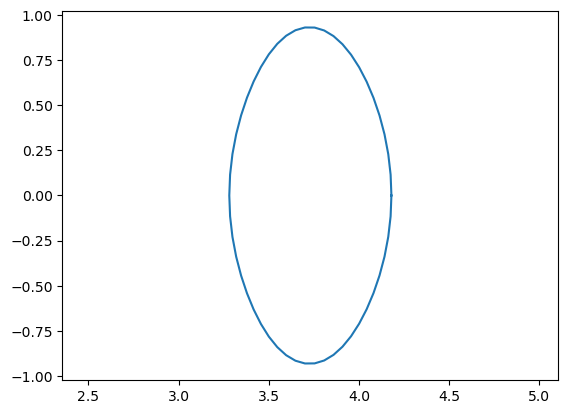

In [6]:
r, z = data.fsplot(phi=np.pi, fs=data.s2fs(1))

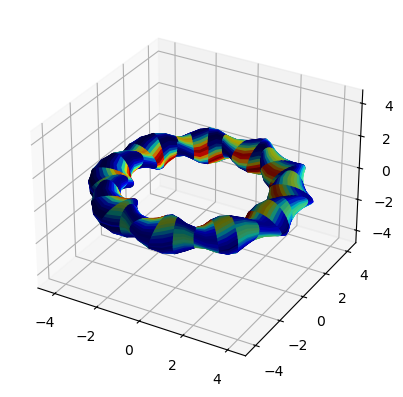

In [7]:
_ = data.modb_on_surface(s=1, ntheta=64, nphi=64, full=True)

In [8]:
#get minimum of B and maximum of B
Bmin = data.psi[0]
Bmax = data.psi[-1]
Bmin, Bmax

(-0.0, -3.2338829999999974)

In [9]:
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')

C:\Users\fuadh\AppData\Local\Temp\ipykernel_26440\3231427270.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


In [10]:
# function to plot the contours for psi on a poloidal cross section
def plot_psi_contours(data, phi=0, nfs=20, ntheta=50, cmap=None):
    theta = np.linspace(0,2*np.pi,num=ntheta+1)
    
    ss = np.linspace(0,1,num=nfs)
    maxPsi = data.psi[-1]
    minPsi = data.psi[0]

    fig, ax = plt.subplots()

    for s in ss:
        fs = data.s2fs(s)
        psi_val = data.psi[fs]
        r = np.zeros(ntheta+1)
        z = np.zeros(ntheta+1)
        for i in range(len(data.xm)):
            m = data.xm[i]
            n = data.xn[i]
            angle = m*theta - n*phi
            r += data.rmnc[fs,i]*np.cos(angle)
            z += data.zmns[fs,i]*np.sin(angle)
        color = (psi_val - minPsi)/(maxPsi - minPsi)
        if cmap is None:
            ax.plot(r,z, label=f's={s:.2f}')
        else:
            ax.plot(r,z, label=f's={s:.2f}', color=cmap(color))
        # choose color based on psi value

    ax.set_aspect('equal')
    ax.set_xlabel('R')
    ax.set_ylabel('Z')
    ax.set_title('Poloidal cross section of psi contours')
    # show colorbar
    if cmap is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=minPsi, vmax=maxPsi))
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Psi')
    return fig, ax


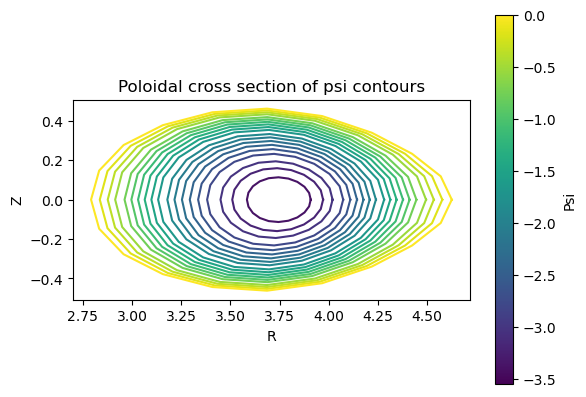

In [11]:
fig, ax = plot_psi_contours(data, cmap=cmap, phi=np.pi/2, ntheta=20)

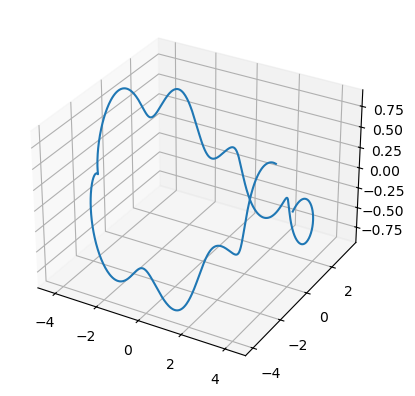

In [12]:
# do field line following to get the field line
x, y, z, modB = data.xyz_on_fieldline(5.8, 0, 0, inrpz=True, phimax=2*np.pi)
# export x, y, z to a .dat file
np.savetxt('fieldline.dat', np.column_stack((x, y, z)))

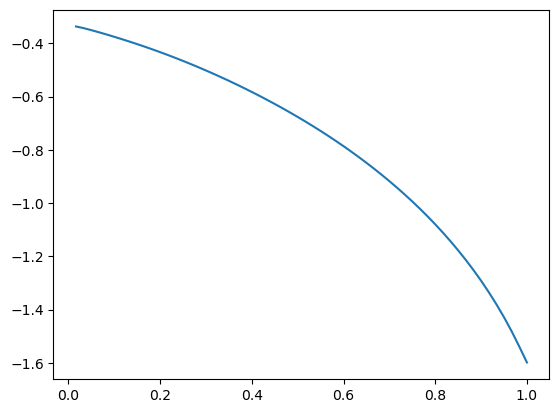

In [13]:
#plt.plot(data.iota)
_ = data.plot_iota(show=True)

In [14]:
r, p, z = 5.8, 0, 0
s = data.rpz2vmec(r, p, z)

In [15]:
s0 = s[0]
fs_ = data.s2fs(s0)
psi_ = data.psi[fs_]
iota_ = data.iota[fs_]

In [16]:
iota_

-1.5985034919096601

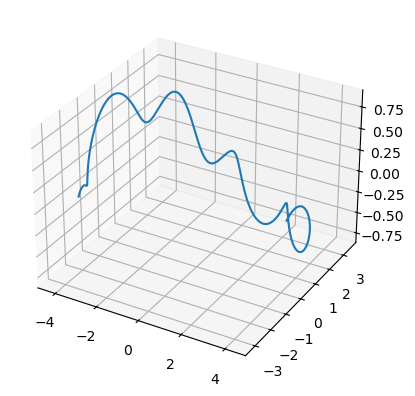

In [17]:
x, y, z, modB = data.xyz_on_fieldline(5.8, 0, 0, inrpz=True, phimax=2*np.pi/abs(iota_))
# export x, y, z to a .dat file
np.savetxt('fieldline.dat', np.column_stack((x, y, z)))

### Exploring Coordinate Systems

Let's see how the VMEC coordinate looks like in the 3D space. Starting from origin of the VMEC coordinate, we will draw the axes of the VMEC coordinate system in the 3D space.

The corresponding equations to convert to cylindrical coordinate are as follows:
$$
r(s, \theta, \phi)=\sum_{n=-N}^N \sum_{m=0}^M R_{n, m}(s) \cos \left(m \theta-n\left(N_p \phi\right)\right)
$$
$$
z(s, \theta, \phi)=\sum_{n=-N}^N \sum_{m=0}^M Z_{n, m}(s) \sin \left(m \theta-n\left(N_p \phi\right)\right)
$$
and $\phi$ is the toroidal angle (which means the same for cylindrical coordinate system), $\theta$ is the poloidal angle, and $s$ is the normalized toroidal flux.

$s$ is calculated as follows in the `read_vmec` function:
$$
s = \frac{\phi}{\phi \mid_{LCFS}}
$$
where $\phi\mid_{LCFS}$ is the toroidal flux at the last closed flux surface (LCFS).

So, in the `vmec2rpz` function, the VMEC coordinate is converted to cylindrical coordinate as follows:
```python
def vmec2rpz(self, s, theta, zeta):
    #interpolate the rmnc, and zmns arrays
    if self.interpr_at != s:
        self.interp_val(s, fourier='r')
    if self.interpz_at != s:
        self.interp_val(s, fourier='z')

    
    angle = self.xm*theta - self.xn*zeta
    r = sum(self.rinterp*np.cos(angle))
    z = sum(self.zinterp*np.sin(angle))

    return r,zeta,z
```
Note: they called $\phi$ as `zeta` in the code.

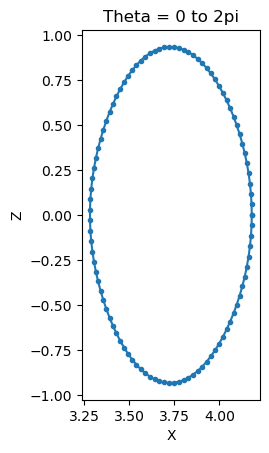

In [18]:
# now, let's start from (0,0,0) in VMEC coordinate and follow theta (0 to 2pi)
# to get the line
theta = np.linspace(0, 2*np.pi, num=100)

# now convert to R, Z, phi
X = np.zeros_like(theta)
Y = np.zeros_like(theta)
Z = np.zeros_like(theta)

for i in range(len(theta)):
    x, y, z = data.vmec2xyz(1, theta[i], np.pi*0)
    X[i] = x
    Y[i] = y
    Z[i] = z

fig, ax = plt.subplots()
ax.plot(X, Z, marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Theta = 0 to 2pi')
ax.set_aspect('equal')

plt.show()

# export X, Y, Z to a .dat file
np.savetxt('data/LCFS.dat', np.column_stack((X, Y, Z)))

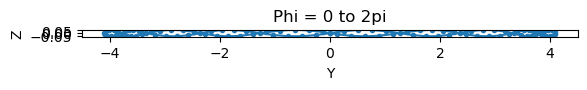

In [19]:
# now let's do the same for phi
phi = np.linspace(0, 2*np.pi, num=100)

# now convert to R, Z, phi
X = np.zeros_like(phi)
Y = np.zeros_like(phi)
Z = np.zeros_like(phi)

for i in range(len(phi)):
    x, y, z = data.vmec2xyz(0.25, 0, phi[i])
    X[i] = x
    Y[i] = y
    Z[i] = z

fig, ax = plt.subplots()

ax.plot(Y, Z, marker='.')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_title('Phi = 0 to 2pi')
ax.set_aspect('equal')

plt.show()

# export X, Y, Z to a .dat file
np.savetxt('data/phi_line.dat', np.column_stack((X, Y, Z)))

These are plotted as 3D lines in GNU Plot and seems like the **VMEC coordinate system is not field following.** Which makes sense because VMEC uses the same $\phi$ angle as the cylindrical coordinate system.

### Field Following Line

On Fusion wiki, rotational transform is defined as:
$$
\frac{\iota}{2\pi} = \frac{d\psi}{d\phi}
$$
where ψ is the poloidal magnetic flux, and Φ the toroidal magnetic flux.

But on XGCS paper, it said "where $\iota(s_i)$ is the rotational transform for the i-th flux surface" which means
$$
\iota = \frac{d\psi}{d\phi}
$$


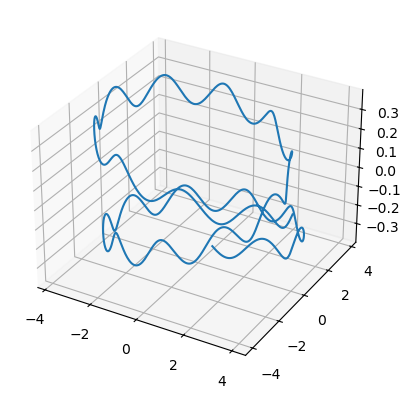

In [20]:
s = 0.25
iota_ = data.iota[data.s2fs(s)]
x, y, z, modB = data.xyz_on_fieldline(s, 0, 0, invmec=True, phimax=2*np.pi/iota_, plot=True)
# export x, y, z to a .dat file
np.savetxt('data/fieldline.dat', np.column_stack((x, y, z)))

### Let's see how the flux suface looks like evolving in the 3D space

In [21]:
# function to plot the contours for psi on a poloidal cross section
def plot_porjected_fluxlines(data, s=1, nphi=20, ntheta=50, cmap=None):
    theta = np.linspace(0,2*np.pi,num=ntheta+1)
    phis = np.linspace(0,2*np.pi,num=nphi+1)
    fs = data.s2fs(s)

    fig, ax = plt.subplots()

    for phi_ in phis:
        r = np.zeros(ntheta+1)
        z = np.zeros(ntheta+1)
        for i in range(len(data.xm)):
            m = data.xm[i]
            n = data.xn[i]
            angle = m*theta - n*phi_
            r += data.rmnc[fs,i]*np.cos(angle)
            z += data.zmns[fs,i]*np.sin(angle)
        color = phi_/(2*np.pi)
        if cmap is None:
            ax.plot(r,z, label=f'p={phi_:.2f}')
            ax.plot(r[0], z[0], '.', color='red')
        else:
            ax.plot(r,z, label=f'p={phi_:.2f}', color=cmap(color))
            ax.plot(r[0], z[0], '.', color=cmap(color))
        # choose color based on psi value

    ax.set_aspect('equal')
    ax.set_xlabel('R')
    ax.set_ylabel('Z')
    ax.set_title('Poloidal cross sections at various phi for specific s = '+str(s))
    # show colorbar
    if cmap is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=2*np.pi))
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Phi (rad)')
    return fig, ax

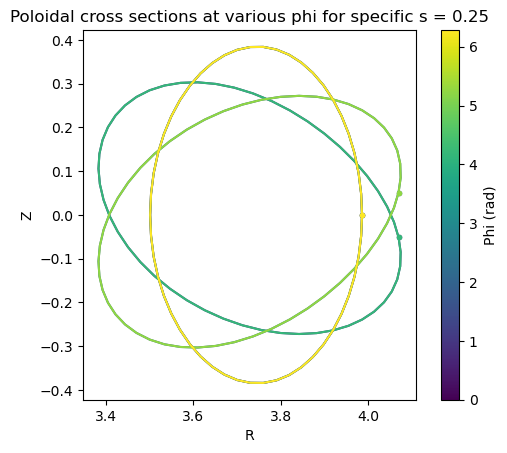

In [22]:
fig, ax = plot_porjected_fluxlines(data, cmap=cmap, s=0.25, nphi=6)

#### Field Following Line on a poloidal plane

In [23]:
# convert to R, Z, phi
R = np.zeros_like(x)
Z = np.zeros_like(y)
phi = np.zeros_like(z)

# cartesian to cylindrical
for i in range(len(x)):
    R[i] = np.sqrt(x[i]**2 + y[i]**2)
    phi[i] = np.arctan2(y[i], x[i])
    Z[i] = z[i]
    ra, za = data.axis(phi[i])
    R[i] -= ra
    Z[i] -= za

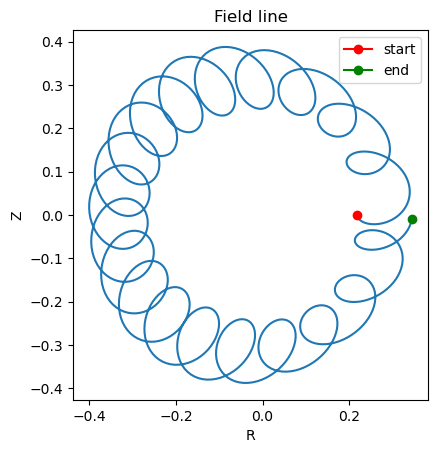

In [24]:
# keep phi unchanged but plot R, Z
fig, ax = plt.subplots()
ax.plot(R, Z)
ax.plot(R[0], Z[0], marker='o', color='r', label='start')
ax.plot(R[-1], Z[-1], marker='o', color='g', label='end')
ax.set_xlabel('R')
ax.set_ylabel('Z')
ax.set_title('Field line')
ax.set_aspect('equal')
ax.legend()

plt.show()

In [25]:
data.vmec2rpz(s, 0, 0), data.vmec2xyz(s, 0, 0)


((3.9851701557210557, 0, 0.0), (3.9851701557210557, 0.0, 0.0))

In [26]:
(x[-1], y[-1], z[-1]), (x[0], y[0], z[0])

((2.4706346142204767, -3.267079910600143, -0.011025296665249377),
 (3.9851701557210557, 0.0, 0.0))

In [27]:
R[-1], Z[-1], R[0], Z[0]

(0.3443296905752553, -0.00954805913512069, 0.21823930530818236, 0.0)

### XGCS's Explanation
This paper said "The poloidal angle relates to a **straight field line coordinate** (s, θ*, φ) by θ* = θ + λ(s, θ, φ), where λ(s, θ, φ) is given as a Fourier series similar to r and z."

$$
\theta^{\star}(i, j, k)=\theta^{\star}(i, j, 1)+\iota\left(s_i\right) \phi(k)
$$

In [28]:
len(data.psi)

61

In [54]:
N_theta_star = 36 
n_fs = len(data.iota)
n_phi = len(data.psi)

theta_star = np.zeros((n_fs, N_theta_star, n_phi))


# get the theta_star for phi = 0
for i in range(0, n_fs):
    for j in range(0, N_theta_star):
        theta_star[i, j, 0] = 2*np.pi*(j)/N_theta_star
        for k in range(1, n_phi):
            theta_star[i, j, k] = theta_star[i, j, 0] + data.iota[i] * data.psi[k]

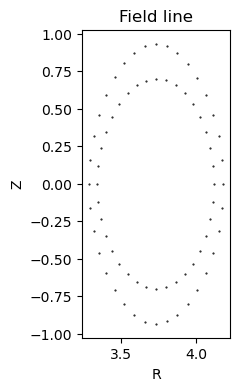

In [62]:
fig, ax = plt.subplots()
# figure size
fig.set_size_inches(12, 4)
ax.set_xlabel('R')
ax.set_ylabel('Z')
ax.set_title('Field line')
ax.set_aspect('equal')

ss = [0.7, 1]

R = np.zeros((N_theta_star, len(ss)))
Z = np.zeros((N_theta_star, len(ss)))
phi = np.zeros((N_theta_star, len(ss)))

for s in range(len(ss)):
    j = s
    s = ss[s]
    for i in range(0, N_theta_star):
        R[i,j], phi[i,j], Z[i,j] = data.vmec2rpz(s, theta_star[data.s2fs(s), i, 0], 0/36)
    
    ax.plot(R[:,j], Z[:,j], 'k.', markersize=1)

# add lines between points
n_lines = 0
initial_point = 0
for i in range(initial_point, initial_point+n_lines):
    ax.plot((R[i,0], R[i,1]),(Z[i,0],Z[i,1]), 'r-')

plt.show()

Instead of doing field following, we can parameterize the flux curve and then just get some equally spaced values, then, if we need the value of $\theta^{\star}$ or $\theta$ at those points, we can just use the `rpz2vmec` function to get the value of $\theta$ at those points.

**Professor said that it is not needed and the vertices I got are okay.**

In [30]:
R[:, 1]

array([0.        , 4.18027532, 4.17586566, 4.16288859, 4.14205013,
       4.11437347, 4.0810089 , 4.04304095, 4.00134664, 3.95654615,
       3.90905763, 3.85923051, 3.80749998, 3.75449541, 3.70105331,
       3.64812732, 3.5966347 , 3.5473109 , 3.50064344, 3.45692345,
       3.41640017, 3.37947484, 3.34684711, 3.31954039, 3.29877827,
       3.28574259, 3.28129255, 3.28574259, 3.29877827, 3.31954039,
       3.34684711, 3.37947484, 3.41640017, 3.45692345, 3.50064344,
       3.5473109 , 3.5966347 , 3.64812732, 3.70105331, 3.75449541,
       3.80749998, 3.85923051, 3.90905763, 3.95654615, 4.00134664,
       4.04304095, 4.0810089 , 4.11437347, 4.14205013, 4.16288859])